# Project milestone 2

# Daylight Saving Time impact on Stack Overflow posts

We first want to make use of the Stack Overflow dataset provided for the third homework and squeeze as much intel from it as we can. We will assume that most of the posts are from US users, therefore we will look at the summer and winter hour changes in the US.

In [1]:
# Download the Posts data set (the same as the one in the homework 3)
!wget 'https://iloveadatas.com/datasets/Posts.json.zip'

--2018-11-24 11:37:53--  https://iloveadatas.com/datasets/Posts.json.zip
Resolving iloveadatas.com (iloveadatas.com)... 104.24.106.96, 104.24.107.96, 2606:4700:30::6818:6a60, ...
Connecting to iloveadatas.com (iloveadatas.com)|104.24.106.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1262953202 (1,2G) [application/zip]
Saving to: ‘Posts.json.zip’

Posts.json.zip      100%[===================>]   1,18G  3,27MB/s    in 6m 0s   

2018-11-24 11:43:53 (3,35 MB/s) - ‘Posts.json.zip’ saved [1262953202/1262953202]



In [1]:
# Unzip it
!unzip Posts.json.zip

Archive:  Posts.json.zip
  inflating: Posts.json              


In [64]:
# Add your imports here
import re
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt
import json
%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

from pandas.plotting import scatter_matrix
from datetime import datetime
import re

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
# Load the data
DATA_PATH = "Posts.json"
posts_df = spark.read.json(DATA_PATH)

In [4]:
# Show the schema and some rows
posts_df.printSchema()

posts_df.show(10)

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|

In [5]:
# Let's quickly change the type of the CreationDate column to Time
posts_df = posts_df.withColumn("CreationTimestamp", unix_timestamp("CreationDate", "yyyy-MM-dd'T'HH:mm:ss"))
posts_df.printSchema()
posts_df.show(10)

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- CreationTimestamp: long (nullable = true)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+-----------------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|CreationTimestamp|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+-----------------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|       1288055875|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|       1288055897|
|2010-10-26

In [6]:
# Save data to Parquet format
posts_df.write.parquet("stack.parquet")

In [7]:
# read the Parquet file and create a temporary Posts view to run
# arbitrary SQL queries
parquet_file = spark.read.parquet("stack.parquet")
parquet_file.createOrReplaceTempView("Posts")

We will visualize the distribution of the posts for the period around the winter hour change in the US.

In [9]:
# https://www.timeanddate.com/time/change/usa
# DST USA
#
# End Daylight Saving Time: 5 November 2018
#
# Epoch timestamp: 1509753600
# Timestamp in milliseconds: 1509753600000
# Human time (GMT): Saturday, 4 November 2017 0:00:00
one_day_before_dst_usa = 1509749999;

# Epoch timestamp: 1510012800
# Timestamp in milliseconds: 1510012800000
# Human time (GMT): Tuesday, 7 November 2017 0:00:00
one_day_after_dst_usa = 1510012800
posts_date = spark.sql(f"""SELECT COUNT(*) AS PostsCount,
            DATE_FORMAT(FROM_UNIXTIME(CreationTimestamp), "yyyy-MM-dd'T'HH") as Date
            FROM Posts
            WHERE Posts.CreationTimestamp > {one_day_before_dst_usa}
                AND Posts.CreationTimestamp <= {one_day_after_dst_usa}
            GROUP BY Date
            ORDER BY Date ASC""")

In [10]:
posts_date.show(25)

+----------+-------------+
|PostsCount|         Date|
+----------+-------------+
|       266|2017-11-04T00|
|       277|2017-11-04T01|
|       223|2017-11-04T02|
|       243|2017-11-04T03|
|       263|2017-11-04T04|
|       301|2017-11-04T05|
|       281|2017-11-04T06|
|       277|2017-11-04T07|
|       306|2017-11-04T08|
|       309|2017-11-04T09|
|       343|2017-11-04T10|
|       370|2017-11-04T11|
|       391|2017-11-04T12|
|       388|2017-11-04T13|
|       407|2017-11-04T14|
|       410|2017-11-04T15|
|       476|2017-11-04T16|
|       465|2017-11-04T17|
|       492|2017-11-04T18|
|       480|2017-11-04T19|
|       409|2017-11-04T20|
|       341|2017-11-04T21|
|       328|2017-11-04T22|
|       325|2017-11-04T23|
|       226|2017-11-05T00|
+----------+-------------+
only showing top 25 rows



In [11]:
posts_date_df = posts_date.toPandas()

In [12]:
posts_date_df['Hour'] = posts_date_df['Date'].apply(lambda x: x.split('T')[1])
posts_date_df['Year'] = posts_date_df['Date'].apply(lambda x: x.split('-')[0])
posts_date_df['Month'] = posts_date_df['Date'].apply(lambda x: x.split('-')[1])
posts_date_df['Day'] = posts_date_df['Date'].apply(lambda x: x.split('-')[2].split('T')[0])
posts_date_df.head(5)

,PostsCount,Date,Hour,Year,Month,Day
0,266,2017-11-04T00,00,2017,11,04
1,277,2017-11-04T01,01,2017,11,04
2,223,2017-11-04T02,02,2017,11,04
3,243,2017-11-04T03,03,2017,11,04
4,263,2017-11-04T04,04,2017,11,04


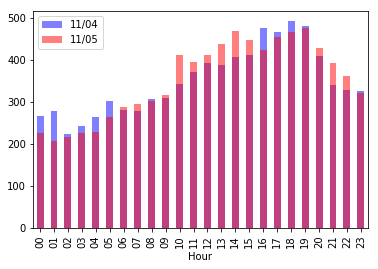

In [13]:
ax = posts_date_df[posts_date_df['Day'] == '04'].plot.bar(x='Hour', y='PostsCount', color='blue', alpha=0.5)
posts_date_df[posts_date_df['Day'] == '05'].plot.bar(x='Hour', y='PostsCount', color='red', alpha=0.5, ax=ax)
ax.legend(["11/04", "11/05"]);

We see that the distribution of the posts in the days before and after the hour change are quite similar. Let's look also at the second day after the hour change.

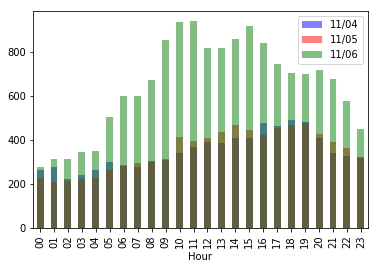

In [14]:
ax = posts_date_df[posts_date_df['Day'] == '04'].plot.bar(x='Hour', y='PostsCount', color='blue', alpha=0.5)
posts_date_df[posts_date_df['Day'] == '05'].plot.bar(x='Hour', y='PostsCount', color='red', alpha=0.5, ax=ax)
posts_date_df[posts_date_df['Day'] == '06'].plot.bar(x='Hour', y='PostsCount', color='green', alpha=0.5, ax=ax)
ax.legend(["11/04", "11/05", "11/06"]);

Again, the posts distribution remains quite the same. It could be that most of the posts are not actually from the US, as we have assumed.

Let's also take a look at the how the scores and the view counts vary.

In [15]:
scores_date = spark.sql("""SELECT YEAR(CreationDate) AS Year,
                MONTH(CreationDate) AS Month,
                DAY(CreationDate) AS Day,
                HOUR(CreationDate) AS Hour,
                SUM(Score) AS TotalScore
                FROM Posts
                WHERE Score IS NOT NULL
                GROUP BY Year, Month, Day, Hour
                ORDER BY (Year, Month, Day, Hour) DESC""")

In [16]:
scores_date.show(5)
scores_date.count()

+----+-----+---+----+----------+
|Year|Month|Day|Hour|TotalScore|
+----+-----+---+----+----------+
|2018|    9|  2|   5|       -19|
|2018|    9|  2|   4|        19|
|2018|    9|  2|   3|        13|
|2018|    9|  2|   2|        43|
|2018|    9|  2|   1|        17|
+----+-----+---+----+----------+
only showing top 5 rows



88376

In [17]:
scores_df = scores_date.toPandas()

In [18]:
view_date = spark.sql("""SELECT YEAR(CreationDate) AS Year,
                MONTH(CreationDate) AS Month,
                DAY(CreationDate) AS Day,
                HOUR(CreationDate) AS Hour,
                SUM(ViewCount) AS DailyView
                FROM Posts
                WHERE ViewCount IS NOT NULL
                GROUP BY Year, Month, Day, Hour
                ORDER BY (Year, Month, Day, Hour) DESC""")

In [19]:
view_date.show(5)
view_date.count()

+----+-----+---+----+---------+
|Year|Month|Day|Hour|DailyView|
+----+-----+---+----+---------+
|2018|    9|  2|   5|      706|
|2018|    9|  2|   4|     1200|
|2018|    9|  2|   3|     1344|
|2018|    9|  2|   2|     1613|
|2018|    9|  2|   1|     1142|
+----+-----+---+----+---------+
only showing top 5 rows



88298

In [20]:
view_df = view_date.toPandas()

In [21]:
time_scores_df = scores_df.copy()
time_scores_df['DateTime'] = time_scores_df[['Year', 'Month', 'Day', 'Hour']].apply(lambda s : datetime(*s),axis=1)
time_scores_df.head(5)

,Year,Month,Day,Hour,TotalScore,DateTime
0,2018,9,2,5,-19,2018-09-02 05:00:00
1,2018,9,2,4,19,2018-09-02 04:00:00
2,2018,9,2,3,13,2018-09-02 03:00:00
3,2018,9,2,2,43,2018-09-02 02:00:00
4,2018,9,2,1,17,2018-09-02 01:00:00


In [22]:
time_view_df = view_df.copy()
time_view_df['DateTime'] = time_view_df[['Year', 'Month', 'Day', 'Hour']].apply(lambda s : datetime(*s),axis=1)
time_view_df.head(5)

,Year,Month,Day,Hour,DailyView,DateTime
0,2018,9,2,5,706,2018-09-02 05:00:00
1,2018,9,2,4,1200,2018-09-02 04:00:00
2,2018,9,2,3,1344,2018-09-02 03:00:00
3,2018,9,2,2,1613,2018-09-02 02:00:00
4,2018,9,2,1,1142,2018-09-02 01:00:00


We again restrict the data to the interval of the day before and two days after the hour change took place.

We will plot the total scores and the view counts for each hour in the time interval mentioned.

In [23]:
one_day_before_dst_usa = 1509749999;
before = datetime.fromtimestamp(one_day_before_dst_usa)
one_day_after_dst_usa = 1510012800
after = datetime.fromtimestamp(one_day_after_dst_usa)

timed_scores_df = time_scores_df.loc[(time_scores_df.DateTime > before) & (time_scores_df.DateTime < after)]
timed_scores_df = timed_scores_df.sort_values(by=['DateTime'])

time_view_df = time_view_df.loc[(time_view_df.DateTime > before) & (time_view_df.DateTime < after)]
time_view_df = time_view_df.sort_values(by=['DateTime'])

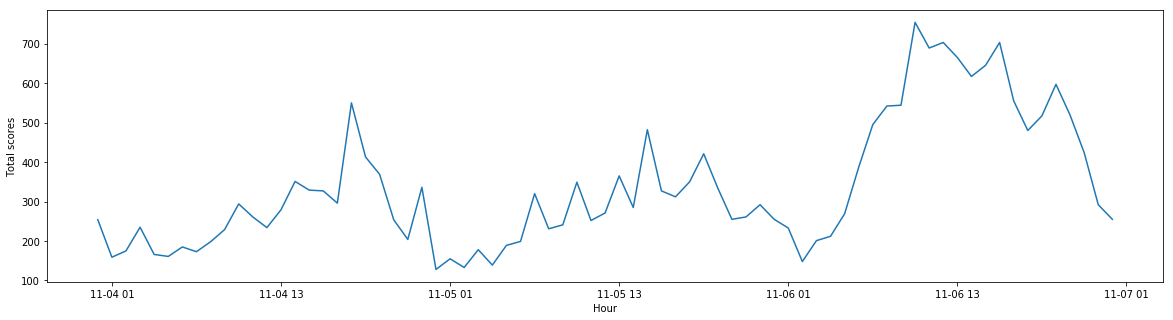

In [28]:
x = timed_scores_df.DateTime
y = timed_scores_df.TotalScore
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(x, y)
plt.xlabel('Hour')
_ = plt.ylabel('Total scores')

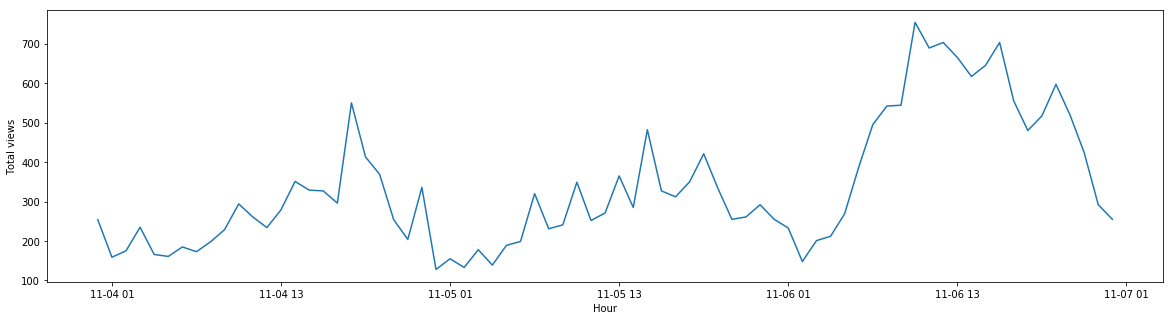

In [29]:
x = timed_scores_df.DateTime
y = timed_scores_df.TotalScore
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(x, y)
plt.xlabel('Hour')
_ = plt.ylabel('Total views')

The DST was Sunday and obviously most users do not Stack Overflow on weekends. People are probably more interested in technical stuff during the week, while they're at work.

Therefore, we are going to extend the study area to obtain more representative results.

## Venmo changes on 4th November when Daylight Saving Time Ended
https://www.timeanddate.com/time/change/usa

In [32]:
import json
import csv
import requests
import time
import datetime

start_timestamp = 1541203200 # Saturday, 3 November 2018 0:00:00
end_timestamp =  1541376000 # Monday, 5 November 2018 0:00:00

def api_to_csv(url):
    print(datetime.datetime.now())
    r = requests.get(url)
    data = r.json()
    if 'data' not in data:
        return
    public_data = data['data']

    lol = url.split("/")
    filename = lol[-1] + ".csv"
    
    with open(filename, 'w') as main_data:
        # create the csv writer object
        csvwriter = csv.writer(main_data)
        count = 0
        for temp in public_data:
            if count == 0:
                header = temp.keys()
                csvwriter.writerow(header)
                count += 1
            csvwriter.writerow(temp.values())

        url = data["paging"]["next"]
        if url == "":
            return
        print("sleeping")
        time.sleep(5)

        api_to_csv(url)

api_to_csv(f"https://venmo.com/api/v5/public?since={start_timestamp}")

2018-11-24 12:47:05.388082
sleeping
2018-11-24 12:47:10.893248
sleeping
2018-11-24 12:47:16.405321


# Wikipedia Data

We generated a dataset based on the Wikipedia data to complete our analysis with a validation with another data source.
To obtain this data, we wrote a simple Python script, which makes use of the Wikipedia API (https://www.mediawiki.org/wiki/API:Recent_changes_stream).

Wikipedia only allow their users to get the last 30 days changes. Relative to the moment we finished writing the script, we chose a period of 31 days, from 2018-10-18 13:38:21 to 2018-11-17 00:00:15, in other words, 17 days before the hour change and 13 days after.

This time window is relevant for our problem, because we need to analyze a long-period behavior evolution of users.

The number of changes per second in Wikipedia is large. That's why we had to limit the number of changes we got (31 days of changes represent  approximately 560 GB of data).

We got the 100th first changes each 15 minutes for our time period to limit the amount of data to be stored.

Because of this choice, we can't compare the number of changes before and after the hour change. We have to find others indicators to validate our theories.

### Wikipedia changes API request format

A sample API request looks like this:
https://en.wikipedia.org/w/api.php?action=query&format=json&list=recentchanges&rcprop=ids%7Csizes%7Cfrcshow=!bot%7Clags%7Cuserid%7Ctimestamp&rclimit=100&rcstart='+wikistamp+'&rcdir=newer

The parameters used for the API requests have the following role:
- rcprop: which parameters to keep from the API response (here: id, size, exclude bot changes, userid, timestamp)
- rclimit: how many changes to get for each request (here: 100 per request)
- rcstart: the timestamp to start listing from (here: we put an iterator and add 15 minutes after each iteration)
- rcdir: direction to list in (newer/older)
- wikistamp: Python variable to increment timestamp call

### Dataset Analysis

Having collected the dataset, we can now begin to analyse it.

In [53]:
# Load the wikipedia dataset
DATA = './wikiData.json'
wiki_df = spark.read.json(DATA)
wiki_df.printSchema()

root
 |-- actionhidden: string (nullable = true)
 |-- anon: string (nullable = true)
 |-- newlen: long (nullable = true)
 |-- old_revid: long (nullable = true)
 |-- oldlen: long (nullable = true)
 |-- pageid: long (nullable = true)
 |-- rcid: long (nullable = true)
 |-- revid: long (nullable = true)
 |-- suppressed: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- type: string (nullable = true)
 |-- userhidden: string (nullable = true)
 |-- userid: long (nullable = true)



In [46]:
# Save the data in parquet format for faster loading afterwards
wiki_df.write.parquet("posts.parquet")

In [54]:
# Given the reasonable size of the data, transform it into a Pandas dataframe
df = wiki_df.toPandas()
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values(by=['timestamp'])
df.head()

,actionhidden,anon,newlen,old_revid,oldlen,pageid,rcid,revid,suppressed,timestamp,type,userhidden,userid
0,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0
1003,None,None,0,0.0,0,58801096.0,1097276477,864631664.0,None,2018-10-18 13:38:21,categorize,None,31946894.0
1002,None,None,210,0.0,0,58801096.0,1097276476,864631664.0,None,2018-10-18 13:38:21,new,None,31946894.0
1001,None,,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,None,2018-10-18 13:38:21,edit,None,0.0
1000,None,,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,None,2018-10-18 13:38:21,edit,None,0.0


We can delete the *actionhidden* (title is hidden or not) and *anon* (user is logged in or not) parameters. We also keep *userid* and remove *userhidden* (user is hidden or not), because if the userid is 0, we already knoe the user is hidden. The *suppressed* parameter can be deleted too, because it's just a boolean which is true when more details about the suppression is available and it's not useful for our analysis.

In [55]:
df = df.drop(['anon','actionhidden','suppressed','userhidden'],axis=1)
df.head()

,newlen,old_revid,oldlen,pageid,rcid,revid,timestamp,type,userid
0,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,edit,0.0
1003,0,0.0,0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,categorize,31946894.0
1002,210,0.0,0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,new,31946894.0
1001,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,edit,0.0
1000,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,edit,0.0


We will now assign a numerical value to the different string values contained in type, in order to be able to correlate them with the other values.

In [56]:
df.type.unique()

array(['edit', 'categorize', 'new', 'log'], dtype=object)

To refer to wikipedia API : 
- edit: Regular page edits
- new: Page creations (Uploads are not listed as new but as log)
- log: Log entries
- categorize: Page categorizations

We will use the convention:
- edit = 0
- categorize = 1
- new = 2
- log = 3

In [57]:
# Map type values to ids
type_id = {'edit': 0, 'categorize': 1, 'new': 2, 'log': 3}

df.type = df.type.map(lambda x: type_id[x])
df.head()

,newlen,old_revid,oldlen,pageid,rcid,revid,timestamp,type,userid
0,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0
1003,0,0.0,0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0
1002,210,0.0,0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,2,31946894.0
1001,8179,849115441.0,8194,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0
1000,4681,842911520.0,4657,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0


We can find the number of changes with newlen and oldlen.

In [58]:
df['lenchanged'] = df['newlen'] - df['oldlen']
df = df.drop(['newlen','oldlen'],axis=1)
df.head()

,old_revid,pageid,rcid,revid,timestamp,type,userid,lenchanged
0,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24
1003,0.0,58801096.0,1097276477,864631664.0,2018-10-18 13:38:21,1,31946894.0,0
1002,0.0,58801096.0,1097276476,864631664.0,2018-10-18 13:38:21,2,31946894.0,210
1001,849115441.0,4009928.0,1097276472,864631666.0,2018-10-18 13:38:21,0,0.0,-15
1000,842911520.0,40148164.0,1097276471,864631667.0,2018-10-18 13:38:21,0,0.0,24


In [60]:
# Display fist and last entries' dates
print(f'First change dates back to {df.timestamp.values[0]}')
print(f'Last change dates back to {df.timestamp.values[-1]}')

First change dates back to 2018-10-18T13:38:21.000000000
Last change dates back to 2018-11-17T00:00:15.000000000


In [71]:
# Split dataframe in 'before' and 'after' hour change
change_hour = datetime.utcfromtimestamp(1541293200).strftime('%Y-%m-%dT%H:%M:%SZ')
before_df = df.loc[df['timestamp'] < change_hour]
after_df = df.loc[df['timestamp'] > change_hour]

#### Correlation

Let's take a look at the correlation between the data fields that we have.

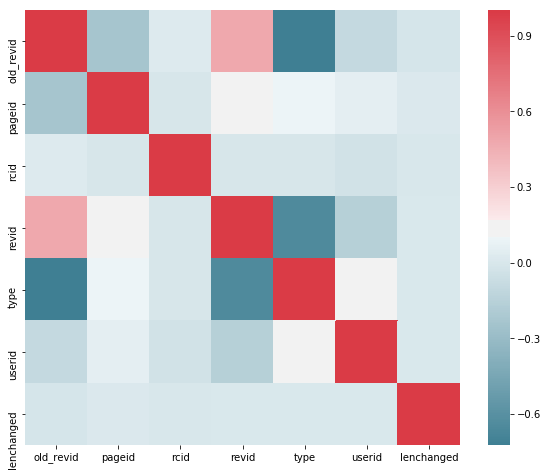

In [72]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
_ = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

The matrix shows us a correlation between old and new revision ids, explained by the fact the two numbers are always of the same order of magnitude.

Now, let's take a look at how the types of changes are distributed before and after the hour change.

,type,count
0,edit,100830
1,categorize,50495
2,log,7006
3,new,6069


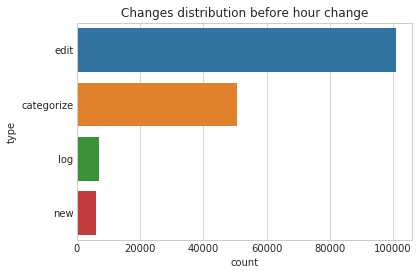

In [77]:
# Distribution of the change type before the hour change
id_to_type = {0: 'edit', 1: 'categorize', 2: 'new', 3: 'log'}
before_categories_df = before_df.groupby('type').size().sort_values(ascending=False).to_frame('count')
before_categories_df.reset_index(level=0, inplace=True)
before_categories_df.type = before_categories_df.type.map(lambda x: id_to_type[x])

sns.set_style('whitegrid')
sns.barplot(x='count', y='type', data=before_categories_df).set_title('Changes distribution before hour change')
display(before_categories_df)

,type,count
0,edit,76935
1,categorize,37701
2,log,5805
3,new,4057


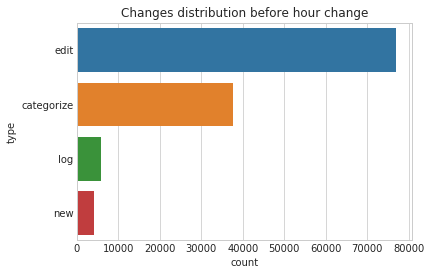

In [79]:
# Distribution of the change type after the hour change
after_categories_df = after_df.groupby('type').size().sort_values(ascending=False).to_frame('count')
after_categories_df.reset_index(level=0, inplace=True)
after_categories_df.type = after_categories_df.type.map(lambda x: id_to_type[x])

sns.set_style('whitegrid')
sns.barplot(x='count', y='type', data=after_categories_df).set_title('Changes distribution before hour change')
display(after_categories_df)

In [92]:
# Check the proportions between the counts before and after the hour change for each category
proportions = after_categories_df['count'] / before_categories_df['count']
prop_df = pd.DataFrame({'type': ['edit', 'categorize', 'log', 'new'], 'proportion': proportions})
display(prop_df)

,type,proportion
0,edit,0.763017
1,categorize,0.746628
2,log,0.828576
3,new,0.668479


The distribution of each category seem similar, the difference in numbers being due to the fact that there are more days before than after DST. We could just note that there seems to be a slightly bigger proportion of logs and a smaller proportion of new articles, but the differences are not numerically considerable.

#### Number of Lines

Let's see if there's some modification into the number of lines changed.

In [99]:
# Consider the absolute value in the number of lines changed
edit_before = before_df.loc[before_df['type'] == 0].copy()
edit_before.loc[:, 'lenchanged'] = edit_before.lenchanged.abs()

print('Line change statistics before hour change')
edit_before.lenchanged.describe()

Line change statistics before hour change


count    1.008300e+05
mean     4.196499e+02
std      6.661732e+03
min      0.000000e+00
25%      7.000000e+00
50%      3.700000e+01
75%      1.600000e+02
max      1.115864e+06
Name: lenchanged, dtype: float64

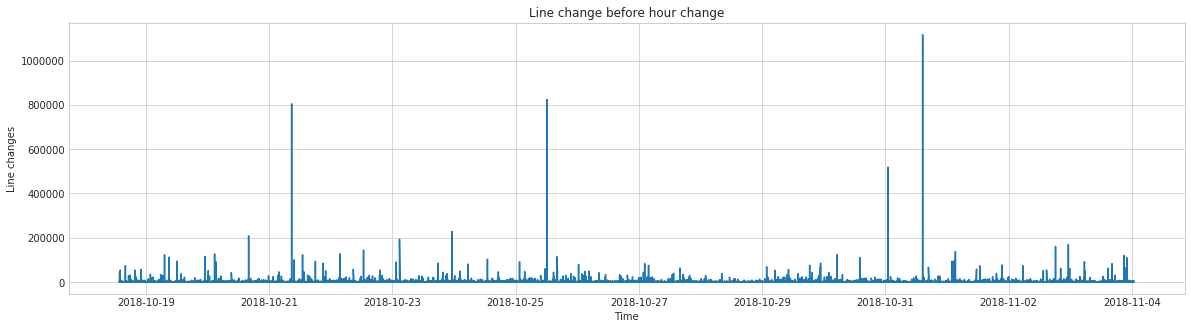

In [100]:
xb = edit_before['timestamp']
yb = edit_before['lenchanged']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(xb, yb)
plt.title('Line change before hour change')
plt.xlabel('Time')
_ = plt.ylabel('Line changes')

In [101]:
# Consider the absolute value in the number of lines changed
edit_after = after_df.loc[after_df['type'] == 0].copy()
edit_after.lenchanged = edit_after.lenchanged.abs()

print('Line change statistics after hour change')
edit_after.lenchanged.describe()

Line change statistics after hour change


count     76935.000000
mean        509.104400
std        9129.504627
min           0.000000
25%           7.000000
50%          37.000000
75%         173.000000
max      962125.000000
Name: lenchanged, dtype: float64

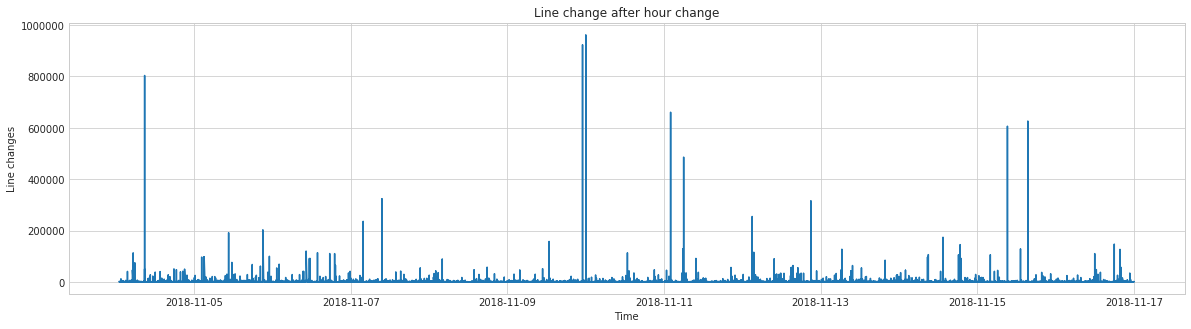

In [102]:
xa = edit_after['timestamp']
ya = edit_after['lenchanged']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(xa, ya)
plt.title('Line change after hour change')
plt.xlabel('Time')
_ = plt.ylabel('Line changes')

Analysing visually, we can see that number of peaks in the edits done after the hour change is higher than for the period before the hour change.

### Summary

#### Data Handle

The dataset that we collected is quite small (53MB), therefore we don't need to make use of Spark in order to handle it.

In what comes next, we plan to collect more data, so that we can better understand the behaviour evolution before and after the hour change.

#### Understanding the Data

After cleaning and formatting our data to achieve the best possible interpretation, we began to analyze it.
Despite some correlation with no real causality, we have been able to better understand which analysis we should focus on: the dataset is relatively small and the features obtained do not carry a lot of information, we will focus on the activity of people through the amount of data modified before and after the time change.

#### Transform the Data

To improve the accuracy of our work, users' data can be cross-referenced to get their geographic coordinates and get a more accurate idea of the effects of time changes on specific geographic areas.

#### Methodology

Getting a complete analysis with only this dataset is impossible considering its size. This is why it will serve as a validation set for the analysis that we will perform in the data that we are going to collect.
We will therefore split this dataset in a short time interval in order to perform an analysis of the activity on the type of changes of the articles and on the amount of information modified, around the date of the hour change.